Lambda School Data Science

*Unit 2, Sprint 2, Module 1*

---

# Decision Trees

 Assignment
- [x] [Sign up for a Kaggle account](https://www.kaggle.com/), if you don’t already have one. Go to our Kaggle InClass competition website. You will be given the URL in Slack. Go to the Rules page. Accept the rules of the competition. Notice that the Rules page also has instructions for the Submission process. The Data page has feature definitions.
- [X] Do train/validate/test split with the Tanzania Waterpumps data.
- [X] Begin with baselines for classification.
- [X] Select features. Use a scikit-learn pipeline to encode categoricals, impute missing values, and fit a decision tree classifier.
- [X] Get your validation accuracy score.
- [X] Get and plot your feature importances.
- [ ] Submit your predictions to our Kaggle competition. (Go to our Kaggle InClass competition webpage. Use the blue **Submit Predictions** button to upload your CSV file. Or you can use the Kaggle API to submit your predictions.)
- [X] Commit your notebook to your fork of the GitHub repo.



## Stretch Goals

### Reading

- A Visual Introduction to Machine Learning
  - [Part 1: A Decision Tree](http://www.r2d3.us/visual-intro-to-machine-learning-part-1/)
  - [Part 2: Bias and Variance](http://www.r2d3.us/visual-intro-to-machine-learning-part-2/)
- [Decision Trees: Advantages & Disadvantages](https://christophm.github.io/interpretable-ml-book/tree.html#advantages-2)
- [How a Russian mathematician constructed a decision tree — by hand — to solve a medical problem](http://fastml.com/how-a-russian-mathematician-constructed-a-decision-tree-by-hand-to-solve-a-medical-problem/)
- [How decision trees work](https://brohrer.github.io/how_decision_trees_work.html)
- [Let’s Write a Decision Tree Classifier from Scratch](https://www.youtube.com/watch?v=LDRbO9a6XPU) — _Don’t worry about understanding the code, just get introduced to the concepts. This 10 minute video has excellent diagrams and explanations._
- [Random Forests for Complete Beginners: The definitive guide to Random Forests and Decision Trees](https://victorzhou.com/blog/intro-to-random-forests/)


### Doing
- [ ] Add your own stretch goal(s) !
- [ ] Define a function to wrangle train, validate, and test sets in the same way. Clean outliers and engineer features. (For example, [what columns have zeros and shouldn't?](https://github.com/Quartz/bad-data-guide#zeros-replace-missing-values) What columns are duplicates, or nearly duplicates? Can you extract the year from date_recorded? Can you engineer new features, such as the number of years from waterpump construction to waterpump inspection?)
- [ ] Try other [scikit-learn imputers](https://scikit-learn.org/stable/modules/impute.html).
- [ ] Make exploratory visualizations and share on Slack.


#### Exploratory visualizations

Visualize the relationships between feature(s) and target. I recommend you do this with your training set, after splitting your data. 

For this problem, you may want to create a new column to represent the target as a number, 0 or 1. For example:

```python
train['functional'] = (train['status_group']=='functional').astype(int)
```



You can try [Seaborn "Categorical estimate" plots](https://seaborn.pydata.org/tutorial/categorical.html) for features with reasonably few unique values. (With too many unique values, the plot is unreadable.)

- Categorical features. (If there are too many unique values, you can replace less frequent values with "OTHER.")
- Numeric features. (If there are too many unique values, you can [bin with pandas cut / qcut functions](https://pandas.pydata.org/pandas-docs/stable/getting_started/basics.html?highlight=qcut#discretization-and-quantiling).)

You can try [Seaborn linear model plots](https://seaborn.pydata.org/tutorial/regression.html) with numeric features. For this classification problem, you may want to use the parameter `logistic=True`, but it can be slow.

You do _not_ need to use Seaborn, but it's nice because it includes confidence intervals to visualize uncertainty.

#### High-cardinality categoricals

This code from a previous assignment demonstrates how to replace less frequent values with 'OTHER'

```python
# Reduce cardinality for NEIGHBORHOOD feature ...

# Get a list of the top 10 neighborhoods
top10 = train['NEIGHBORHOOD'].value_counts()[:10].index

# At locations where the neighborhood is NOT in the top 10,
# replace the neighborhood with 'OTHER'
train.loc[~train['NEIGHBORHOOD'].isin(top10), 'NEIGHBORHOOD'] = 'OTHER'
test.loc[~test['NEIGHBORHOOD'].isin(top10), 'NEIGHBORHOOD'] = 'OTHER'
```


## EDA

In [3]:
# for cheking the installed modules
import sys
# part of the trio
import numpy as np
import pandas as pd
# for CV
from sklearn.model_selection import train_test_split

# pandas profiling broken on local env
# import pandas_profiling
# from pandas_profiling import ProfileReport


In [4]:
# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Kaggle-Challenge/master/data/'
    !pip install category_encoders==2.*
    !pip install pandas-profiling==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'

In [5]:
train = pd.merge(pd.read_csv(DATA_PATH+'train_features.csv'), 
                 pd.read_csv(DATA_PATH+'train_labels.csv'))
test = pd.read_csv(DATA_PATH+'test_features.csv') 
sample_submission = pd.read_csv(DATA_PATH+'sample_submission.csv')

train.shape, test.shape

((59400, 41), (14358, 40))

## Data Cleaning

In [6]:
def Data_cleaning(X):
 
  # make a copy of the data
  X = X.copy()
  # get rid of outliers  
  X['latitude'] = X['latitude'].replace(-2e-08, 0)
    
  # When columns have zeros and shouldn't, they are like null values.
  # So we will replace the zeros with nulls, and impute missing values later.
    
  cols_with_zeros = ['longitude', 'latitude','population','construction_year']
  for col in cols_with_zeros:
    X[col] = X[col].replace(0, np.nan)

  # add try catch to ignore rerun of cell 
  try:        
    # drop redundant column
    X = X.drop(columns='quantity_group')
    X=X.drop('recorded_by',axis=1)

    # change 'unkown' to nan
    X['source_class']=X['source_class'].replace("unknown",np.NaN)

    # not a dup but not usefull %0 variance
  except:
    print("Cell is rerun")

  # define a list of columns to iterate through
  # originially this was an argument for the function but i moved it inside
  column=['funder','installer','region','scheme_name']
  # if a list is passed then make changes for all elements in that list of column names
  if isinstance(column,list):
    for ele in column:
      top10=X[ele].value_counts()[:10].index
      X.loc[~X[ele].isin(top10), ele] = 'other'
  # if one name is passed then just change that one column
  else:
    top10=X[column].value_counts()[:10].index
    X.loc[~X[column].isin(top10), column] = 'other'
  return X


In [7]:
train=Data_cleaning(train)
test=Data_cleaning(test)

In [8]:
def make_split(df,cv=False,shuffle=False):
    '''
        The goal of this function is to make a good set of cross validation dataframes and return them
        takes a bool that determines if a train/val split is used or a train/[cv,cv2,cv3,cv4,cv5] is used
        the other parameter is the dataframe that the split is occuring from
        defualt make_split(df,cv=False)
    '''
    t=[]
    from sklearn.utils import shuffle
    if cv:
        t=[df.sample(frac=(x+1)/5) for x in range(5)]
        return shuffle(df),t
    else:
        return train_test_split(train)
            

In [22]:
target = 'status_group'
ignore=['date_recorded','id',target]
cat_features=[x for x in train.describe(exclude='number').columns.to_list() if x not in ignore]
num_features=[x for x in train.describe(include='number').columns.to_list() if x not in ignore]

# Get a series with the cardinality of the nonnumeric features
cardinality = train[cat_features].select_dtypes(exclude='number').nunique()
# Get a list of all categorical features with cardinality <= 50
cat_features = cardinality[cardinality <= 50].index.tolist()

# set features and target
target = 'status_group'
features = cat_features + num_features

train,val=make_split(train)
train,cv_list=make_split(train,True)

# print all of the sizes out
print("train shape",train.shape,"val shape",val.shape,f"test shape{test.shape}")
print("CV's shapes")
[print(c.shape) for c in cv_list]

# make feature sets and labels
X_train=train[features]
X_val=val[features]
X_cv_list=[c[features] for c in cv_list]
y_train=train[target]
y_val=val[target]
y_cv_list=[c[target] for c in cv_list]
# make test feature set
X_test=test[features]


train shape (33412, 39) val shape (11138, 39) test shape(14358, 38)
CV's shapes
(6682, 39)
(13365, 39)
(20047, 39)
(26730, 39)
(33412, 39)


## set up a pipeline to get a baseline model

# A Mess **todo**:clean

In [23]:
# import preprocessing stuff
from sklearn.pipeline import make_pipeline
from category_encoders import OneHotEncoder
from sklearn.preprocessing import StandardScaler,MinMaxScaler,RobustScaler

# imputers
from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer

# import a bunch of models that i want to test
from sklearn.linear_model import LogisticRegression,SGDClassifier 
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score


In [41]:
from sklearn.ensemble import RandomForestClassifier
model=RandomForestClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None,
                       max_features=0.4, max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=6,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=1000, n_jobs=-1, oob_score=False,
                       random_state=42, verbose=False, warm_start=False)

In [42]:
pipeline=make_pipeline(OneHotEncoder(use_cat_names=True),
                      SimpleImputer(strategy='most_frequent'),
                      StandardScaler(),
                      model)


In [43]:
# hyperopt suggested model
#RandomForestClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
#                       criterion='entropy', max_depth=None,
#                       max_features=0.43626285313652846, max_leaf_nodes=None,
#                       max_samples=None, min_impurity_decrease=0.0,
#                       min_impurity_split=None, min_samples_leaf=1,
#                       min_samples_split=2, min_weight_fraction_leaf=0.0,
#                       n_estimators=11, n_jobs=1, oob_score=False,
#                       random_state=0, verbose=False, warm_start=False)
pipeline.fit(X_train,y_train)
y_pred=pipeline.predict(X_train)
print(f"XGB_pipe:\n\tTRAIN ACCURACY:{accuracy_score(y_pred=y_pred,y_true=y_train)}")
y_pred=pipeline.predict(X_val)
print(f"\tVALIDATION ACCURACY:{accuracy_score(y_pred=y_pred,y_true=y_val)}")


XGB_pipe:
	TRAIN ACCURACY:0.9044056027774452
	VALIDATION ACCURACY:0.8049021368288741


In [40]:
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4, 6]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train, y_train)

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


In [17]:
#from hpsklearn import HyperoptEstimator, any_classifier
#from hyperopt import tpe
#pre_pipe=make_pipeline(OneHotEncoder(use_cat_names=True),
#                            SimpleImputer(),
#                            MinMaxScaler())
#estim = HyperoptEstimator(classifier=any_classifier('clf'),  
#                          algo=tpe.suggest, 
#                          trial_timeout=300)
#X_train=pre_pipe.fit_transform(X_train)

#estim.fit( X_train, y_train )


  0%|          | 0/1 [00:00<?, ?it/s, best loss: ?]

/home/joe/opt/conda/envs/ds-base/lib/python3.7/site-packages/sklearn/ensemble/_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)



  0%|          | 0/1 [00:00<?, ?it/s, best loss: ?]

/home/joe/opt/conda/envs/ds-base/lib/python3.7/site-packages/sklearn/ensemble/_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)



100%|██████████| 1/1 [00:04<00:00,  4.65s/it, best loss: 0.2236812570145903]


NameError: name 'y_test' is not defined

In [20]:
#X_val=pre_pipe.transform(X_val)
#print( estim.score( X_val, y_val ) )
# <<show score here>>
print( estim.best_model() )

{'learner': RandomForestClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None,
                       max_features=0.43626285313652846, max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=11, n_jobs=1, oob_score=False,
                       random_state=0, verbose=False, warm_start=False), 'preprocs': (StandardScaler(copy=True, with_mean=False, with_std=False),), 'ex_preprocs': ()}


## results from diffrent models, baseline was a logistic regression

In [21]:
y_pred=pipe.predict(X_train)
print(f"BASELINE:\n\tTRAIN ACCURACY:{accuracy_score(y_pred=y_pred,y_true=y_train)}")
y_pred=pipe.predict(X_val)
print(f"\tVALIDATION ACCURACY:{accuracy_score(y_pred=y_pred,y_true=y_val)}")

BASELINE:
	TRAIN ACCURACY:0.7414622414622415
	VALIDATION ACCURACY:0.7425845759179093


In [24]:
y_pred=SGDClassifier_pipe.predict(X_train)
print(f"SGDClassifier:\n\tTRAIN ACCURACY:{accuracy_score(y_pred=y_pred,y_true=y_train)}")
y_pred=SGDClassifier_pipe.predict(X_val)
print(f"\tVALIDATION ACCURACY:{accuracy_score(y_pred=y_pred,y_true=y_val)}")

SGDClassifier:
	TRAIN ACCURACY:0.721878650450079
	VALIDATION ACCURACY:0.7237453904120571


In [26]:
y_pred=SVC_pipe.predict(X_train)
print(f"SVC_pipe:\n\tTRAIN ACCURACY:{accuracy_score(y_pred=y_pred,y_true=y_train)}")
y_pred=SVC_pipe.predict(X_val)
print(f"\tVALIDATION ACCURACY:{accuracy_score(y_pred=y_pred,y_true=y_val)}")

SVC_pipe:
	TRAIN ACCURACY:0.7914175771318629
	VALIDATION ACCURACY:0.7725669392336059


In [30]:
y_pred=DecisionTreeClassifier_pipe.predict(X_train)
print(f"DecisionTreeClassifier_pipe:\n\tTRAIN ACCURACY:{accuracy_score(y_pred=y_pred,y_true=y_train)}")
y_pred=DecisionTreeClassifier_pipe.predict(X_val)
print(f"\tVALIDATION ACCURACY:{accuracy_score(y_pred=y_pred,y_true=y_val)}")

DecisionTreeClassifier_pipe:
	TRAIN ACCURACY:0.9965299251013536
	VALIDATION ACCURACY:0.7456309122975789


In [32]:
# min_samples_leaf=20
y_pred=DecisionTreeClassifier_pipe.predict(X_train)
print(f"DecisionTreeClassifier_pipe:\n\tTRAIN ACCURACY:{accuracy_score(y_pred=y_pred,y_true=y_train)}")
y_pred=DecisionTreeClassifier_pipe.predict(X_val)
print(f"\tVALIDATION ACCURACY:{accuracy_score(y_pred=y_pred,y_true=y_val)}")

DecisionTreeClassifier_pipe:
	TRAIN ACCURACY:0.7983920841063699
	VALIDATION ACCURACY:0.7524450857784191


In [38]:
# min_samples_split=10
# min_samples_leaf=10
y_pred=DecisionTreeClassifier_pipe.predict(X_train)
print(f"DecisionTreeClassifier_pipe:\n\tTRAIN ACCURACY:{accuracy_score(y_pred=y_pred,y_true=y_train)}")
y_pred=DecisionTreeClassifier_pipe.predict(X_val)
print(f"\tVALIDATION ACCURACY:{accuracy_score(y_pred=y_pred,y_true=y_val)}")

DecisionTreeClassifier_pipe:
	TRAIN ACCURACY:0.8297258297258298
	VALIDATION ACCURACY:0.7594997594997595


In [40]:
# min_samples_split=10
# min_samples_leaf=10
y_pred=DecisionTreeClassifier_pipe.predict(X_train)
print(f"DecisionTreeClassifier_pipe:\n\tTRAIN ACCURACY:{accuracy_score(y_pred=y_pred,y_true=y_train)}")
y_pred=DecisionTreeClassifier_pipe.predict(X_val)
print(f"\tVALIDATION ACCURACY:{accuracy_score(y_pred=y_pred,y_true=y_val)}")

DecisionTreeClassifier_pipe:
	TRAIN ACCURACY:0.829863258434687
	VALIDATION ACCURACY:0.7625460958794292


In [20]:

#              XGBClassifier(objective = 'multi:softmax', booster = 'gbtree', nrounds = 'min.error.idx', 
#                      num_class = 3, maximize = False, eval_metric = 'merror', eta = .1,
#                      max_depth = 14, colsample_bytree = .4)

y_pred=XGB_pipe.predict(X_train)
print(f"XGB_pipe:\n\tTRAIN ACCURACY:{accuracy_score(y_pred=y_pred,y_true=y_train)}")
y_pred=XGB_pipe.predict(X_val)
print(f"\tVALIDATION ACCURACY:{accuracy_score(y_pred=y_pred,y_true=y_val)}")

XGB_pipe:
	TRAIN ACCURACY:0.9383164983164983
	VALIDATION ACCURACY:0.8111784511784512


In [ ]:
import pickle as salt

In [ ]:
try:
  file_f=open('SVC_waterwells.pickle','wb')  
  salt.dump(SVC_pipe.named_steps['svc'],file_f)
except Exception as e:
  print(e)
finally:
  file_f.close()


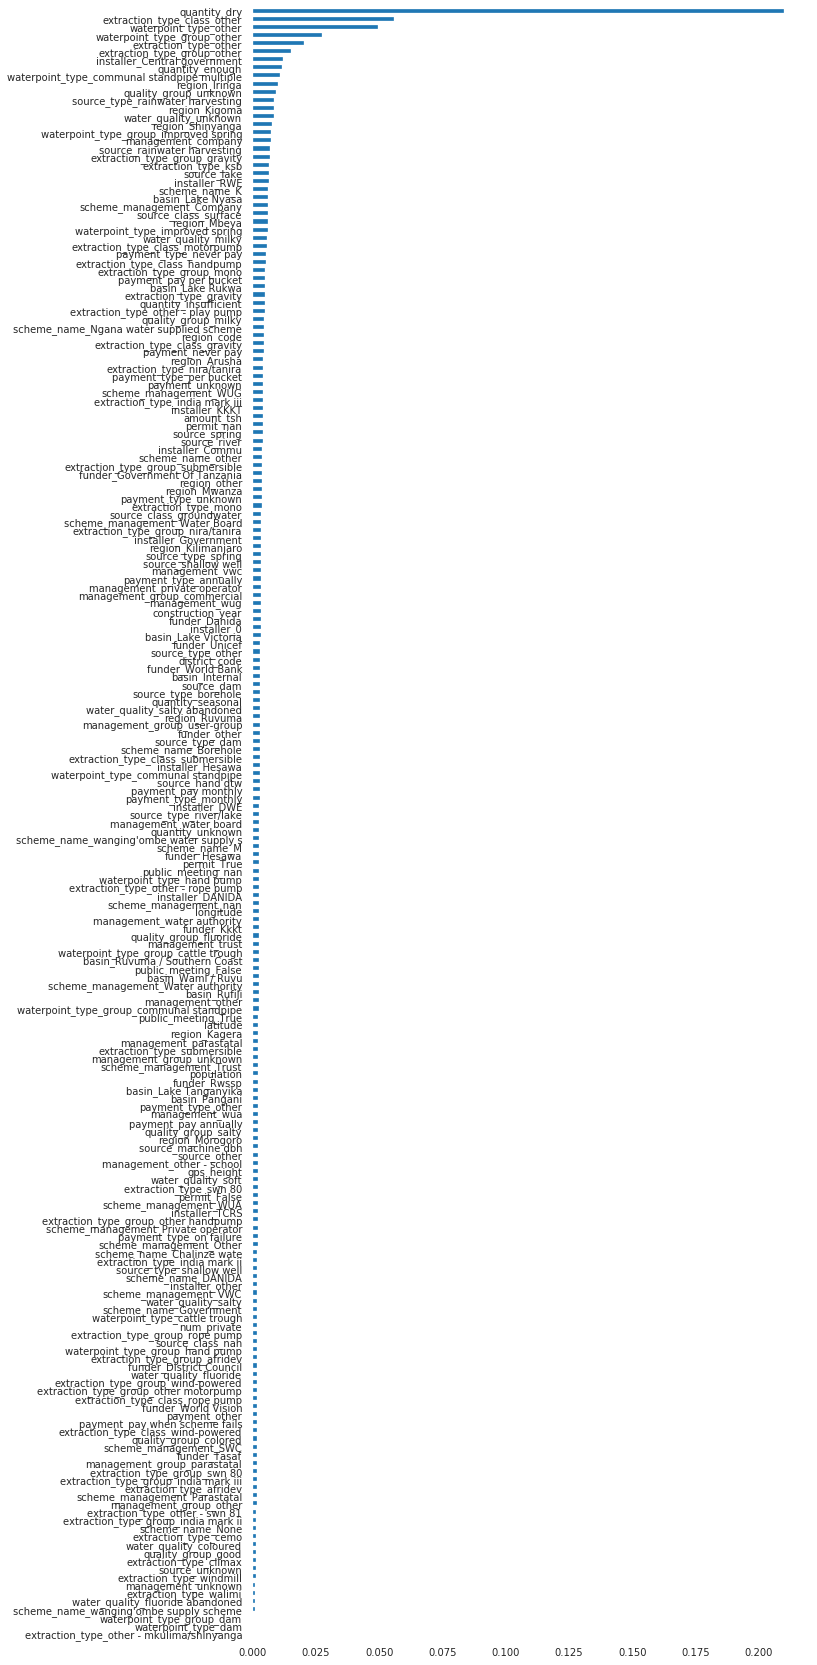

In [48]:
import matplotlib.pyplot as plt
# plotting feature importance

model = XGB_pipe.named_steps['XGBClassifier'.lower()]

encoder = XGB_pipe.named_steps['onehotencoder']
encoded_columns = encoder.transform(X_val).columns
importances = pd.Series( model.feature_importances_ , encoded_columns)

plt.figure(figsize=(10,30))
importances.sort_values().plot.barh()

In [58]:
y_pred=XGB_pipe.predict(X_test)

In [59]:
test.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,payment,payment_type,water_quality,quality_group,quantity,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,50785,0.0,2013-02-04,other,1996,other,35.290799,-4.059696,Dinamu Secondary School,0,...,never pay,never pay,soft,good,seasonal,rainwater harvesting,rainwater harvesting,surface,other,other
1,51630,0.0,2013-02-04,Government Of Tanzania,1569,DWE,36.656709,-3.309214,Kimnyak,0,...,never pay,never pay,soft,good,insufficient,spring,spring,groundwater,communal standpipe,communal standpipe
2,17168,0.0,2013-02-01,other,1567,other,34.767863,-5.004344,Puma Secondary,0,...,never pay,never pay,soft,good,insufficient,rainwater harvesting,rainwater harvesting,surface,other,other
3,45559,0.0,2013-01-22,other,267,other,38.058046,-9.418672,Kwa Mzee Pange,0,...,unknown,unknown,soft,good,dry,shallow well,shallow well,groundwater,other,other
4,49871,500.0,2013-03-27,other,1260,other,35.006123,-10.950412,Kwa Mzee Turuka,0,...,pay monthly,monthly,soft,good,enough,spring,spring,groundwater,communal standpipe,communal standpipe


In [60]:
export=pd.DataFrame(index=test['id'],data=y_pred,columns=[target])
export.reset_index(inplace=True)

In [61]:
export.to_csv("submission.csv",index=False)